## Robot programming workshop 07

<div class="alert alert-block alert-info">For this workshop you will be using the dr20 robot and a new environment, a more complex 'maze' with straight lines and sign posts, 02_Maze_scene_vrep.ttt, that we can use to further test the dr20's array of sensors including its front facing camera. The goal of this workshop is to interface with the robot class and write some code to pilot the robot around the 'maze' to take photos of the sign posts at each junction. <i>We will then hopefully be able to use these photos to later train a simple neural network towards helping to solve the maze in a later workshop.</i> Make sure you have save sim.py, simConst.py (or vrepConst.py) and remoteApi.dll files to a directory and also downloaded the <b>02_Maze_scene_vrep.ttt</b> to your working folder (a known location)</div>

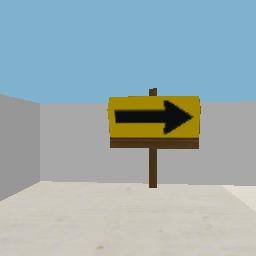

<font color="red"><b>Task 1:</b></font> Download the <b>short_path_vrep.ttt</b> to a working directory where you have saved sim.py, simConst.py (or vrepConst.py) and remoteApi.dll and change your path to that directory.  

In [1]:
import os
# set this path to your working folder
desiredPath = r"C:\Users\mahic\Downloads\dir\ROBOTICS WORKBOOKS\Files" 
os.chdir(desiredPath)
print("Current working directory: {}".format(os.getcwd()))   # sanity check

try:
    import sim
except:
    print ('--------------------------------------------------------------')
    print ('"sim.py" could not be imported. This means very probably that')
    print ('either "sim.py" or the remoteApi library could not be found.')
    print ('Make sure both are in the same folder as this file,')
    print ('or appropriately adjust the file "sim.py"')
    print ('--------------------------------------------------------------')
    print ('')

import time
import sys
# used for the camera data
import numpy as np
from PIL import Image
import csv

## choose the correct version of the library to import  
if os.path.isfile('/'.join([desiredPath, 'vrepConst.py'])):
    import vrepConst as wlvConst
else:
    import simConst as wlvConst

Current working directory: C:\Users\mahic\Downloads\dir\ROBOTICS WORKBOOKS\Files


<font color="red"><b>Task 2:</b></font> Just a test that the PIL image library is working and we can display images on our machine.  The show method should launch a default viewer on your system and display the image.  

In [2]:
# # Location of the image
img = Image.open("pepper.jpg")
img.show()

<font color="red"><b>Task 3:</b></font> The following is our instance of the Dr20Robot which will initialise the camera sensor and add code to capture an image (allowing the robot to 'see') and conduct some post processing to record the information in the image.  Note: we need to use this version of the camera handing code as the code for this in the base class does not work.  

In [3]:
from Dr20Robot import Dr20Robot_Interface

class Dr20Robot(Dr20Robot_Interface):

    def __init__(self, sim, clientID):
        Dr20Robot_Interface.__init__(self, sim, clientID)
        errCode, self.cameraSensor = sim.simxGetObjectHandle(clientID, "Vision_sensor", sim.simx_opmode_oneshot_wait )
        if errCode > 0:
            print("*** Error getting initialising the camera {}".format(errCode))
        ## initialise sensor - needs an initial call to fill the sensor buffer
        returnCode,resolution,raw_image=sim.simxGetVisionSensorImage(clientID, self.cameraSensor, 0,sim.simx_opmode_streaming)

    # this will be the main-loop for the robot behaviour
    def robotBehaviour(self):
        # Read sensor data
        sensReading = self.readSensors()
        front_left_camera = sensReading[0]
        front_camera = sensReading[2]
        front_right_camera = sensReading[3]
        rear_left_camera = sensReading[1]
        rear_right_camera = sensReading[4]
        
        
        
        print("Sensor Readings:", front_left_camera, front_right_camera, front_camera)
      
        self.move_forward(2.9)
        if front_camera < 0.24:
                self.stop()
                time.sleep(1)
                image = self.camera_image()
                self.processImage(image)
                self.stop()
                if rear_right_camera > 1.1:
                    self.rotate_right(0.4)
                    time.sleep(1.1)
                    self.stop()
                elif rear_left_camera > 0.3 and rear_left_camera > 0.3:
                    time.sleep(1)
                    self.rotate_left(0.4)
                    time.sleep(1.1)
                    self.stop()
                elif rear_right_camera > 0.4:
                    self.rotate_right(0.5)
                    time.sleep(1.1)
                    self.stop()
                elif rear_left_camera > 0.4:
                    time.sleep(2)
                    self.rotate_left(0.4)
                    time.sleep(1.1)
                    self.stop()
                elif rear_left_camera < 0.1:
                    time.sleep(2)
                    self.rotate_left(0.4)
                    time.sleep(1.1)
                    self.stop()

                else:
                    self.move_forward(2.9)

                    startTime=time.time()
                    ## move forward
                    while time.time()-startTime < TimeOutLimit:
                    
                        sensorReading = [bot.left_sensor(),bot.mid_sensor(),bot.right_sensor()]
                        print(sensorReading) ## display the sensor data
                        if sensorReading[0] == False and sensorReading[1] == True and sensorReading[2] == False:
                            bot.move_forward(04)
                        elif sensorReading[0] == True and sensorReading[1] == True and sensorReading[2] == True:
                            bot.move_forward(0.4)
                        elif sensorReading[0] == True and sensorReading[1] == True and sensorReading[2] == False:
                            bot.rotate_left(0.09)
                        elif sensorReading[0] == False and sensorReading[1] == True and sensorReading[2] == True:
                            bot.rotate_right(0.09)
                        elif sensorReading[0] == True and sensorReading[1] == False and sensorReading[2] == False:
                            bot.rotate_left(0.09)
                        elif sensorReading[0] == False and sensorReading[1] == False and sensorReading[2] == True:
                            bot.rotate_right(0.09)
    
                            time.sleep(1) ## wait
                        ## Stop the robot
                        bot.stop()
                        time.sleep(0.5) ## delay to execute the command
                        sim.simxFinish(-1) ## just in case, close all opened connections
                        print("...done")


                
     
                
        
        
    # display the image to and screen and/or save to file 
    def processImage(self, array_raw):
        (h, w, d) = array_raw.shape
        print("width={}, height={}, depth={}".format(w, h, d))
        ## reverse the arry otherwise it is upsidedown and back to front 
        array = array_raw[::-1]

        if False: ## set True to save the raw array data to a csv file 
            list_columns = ['R', 'G', 'B'] 
            np_array_col = np.array(list_columns)
            with open('data1.csv', 'w') as csvfile:
                write = csv.writer(csvfile)
                write.writerow(np_array_col)
                write.writerows(array)

        ## convert to a PIL image 
        img = Image.fromarray(array)

        if True: ## set True to save the image data to a file 
            img.save("image.jpg")
        if True: ## set True to display each image as it is captured
            img.show()

        
    def camera_image(self):
        ## return the value from the camera sensor
        returnCode,resolution,raw_image=self._sim.simxGetVisionSensorImage(self.clientID, self.cameraSensor, 0,self._sim.simx_opmode_streaming)
        time.sleep(0.2)
        returnCode,resolution,raw_image=self._sim.simxGetVisionSensorImage(self.clientID, self.cameraSensor, 0,self._sim.simx_opmode_buffer)
        image = np.array(raw_image).astype(np.uint8)
        if False:   # set to True for image handling debug info
            print(returnCode)
            print(resolution)
            print(len(raw_image))
        image.resize([resolution[0],resolution[0],3])
        return image

SyntaxError: leading zeros in decimal integer literals are not permitted; use an 0o prefix for octal integers (925059343.py, line 68)

<font color="red"><b>Task 4:</b></font> Connects to the simulator, creates the robot, sets it to run, and closes the network connection once the robot is done.  

In [ ]:
def mazeRobotTest():
    print ('Program started')
    sim.simxFinish(-1) # just in case, close all opened connections

    clientID=sim.simxStart('127.0.0.1',19997,True,True,5000,5) # Connect to CoppeliaSim

    if clientID != -1:
        print ('Connected to remote API server')
    else:
        print('Connection failed!!')
        sys.exit('Could not connect')

    ## Create the robot object
    bot = Dr20Robot(sim, clientID)
    bot.robotBehaviour()
    time1 = time.time()
    bot.stop()
    time.sleep(1)
    bot.rotate_right(0.2)
    time.sleep(0.1)

    
    
    while time.time() - time1 < 10000:
        bot.robotBehaviour()
            
    
        
        

    bot.stop()
    time.sleep(0.5)    ## delay to execute the command
    sim.simxFinish(-1) ## just in case, close all opened connections
    print("...done")

<font color="red"><b>Task 5:</b></font> Run the V-rep/CoppeliaSim Dr20 robot  (remember to also run the scene) and read the sensor data. <b>Note: the processImage function blocks/halts the program waiting for the image window to be closed before proceeding</b> 

In [ ]:
try:
    mazeRobotTest()
except Exception as ex:
    print("Exception was: {}".format(ex))
    sim.simxFinish(-1) ## just in case, close all opened connections
    print("...uh oh, something went wrongt!!!")

Sensor Readings: 1.0 1.0 1.0
Sensor Readings: 1.0 1.0 1.0
Sensor Readings: 1.0 1.0 1.0
Sensor Readings: 1.0 1.0 1.0
Sensor Readings: 1.0 1.0 1.0
Sensor Readings: 1.0 1.0 1.0
Sensor Readings: 1.0 1.0 1.0
Sensor Readings: 1.0 1.0 1.0
Sensor Readings: 1.0 1.0 1.0
Sensor Readings: 1.0 1.0 1.0
Sensor Readings: 1.0 1.0 1.0
Sensor Readings: 1.0 1.0 1.0
Sensor Readings: 1.0 1.0 1.0
Sensor Readings: 1.0 1.0 1.0
Sensor Readings: 1.0 1.0 1.0
Sensor Readings: 1.0 1.0 1.0
Sensor Readings: 1.0 1.0 1.0
Sensor Readings: 1.0 1.0 1.0
Sensor Readings: 1.0 1.0 1.0
Sensor Readings: 1.0 1.0 1.0
Sensor Readings: 1.0 1.0 1.0
Sensor Readings: 1.0 1.0 1.0
Sensor Readings: 1.0 1.0 1.0
Sensor Readings: 1.0 1.0 1.0
Sensor Readings: 1.0 1.0 1.0
Sensor Readings: 1.0 1.0 1.0
Sensor Readings: 1.0 1.0 1.0
Sensor Readings: 1.0 1.0 1.0
Sensor Readings: 1.0 1.0 1.0
Sensor Readings: 1.0 1.0 1.0
Sensor Readings: 1.0 1.0 1.0
Sensor Readings: 1.0 1.0 1.0
Sensor Readings: 1.0 1.0 1.0
Sensor Readings: 1.0 1.0 1.0
Sensor Reading

Sensor Readings: 1.0 1.0 1.0
Sensor Readings: 1.0 1.0 1.0
Sensor Readings: 1.0 1.0 1.0
Sensor Readings: 1.0 1.0 1.0
Sensor Readings: 1.0 1.0 1.0
Sensor Readings: 1.0 1.0 1.0
Sensor Readings: 1.0 1.0 1.0
Sensor Readings: 1.0 1.0 1.0
Sensor Readings: 1.0 1.0 1.0
Sensor Readings: 1.0 1.0 1.0
Sensor Readings: 1.0 1.0 1.0
Sensor Readings: 1.0 1.0 1.0
Sensor Readings: 1.0 1.0 1.0
Sensor Readings: 1.0 1.0 1.0
Sensor Readings: 1.0 1.0 1.0
Sensor Readings: 1.0 1.0 1.0
Sensor Readings: 1.0 1.0 1.0
Sensor Readings: 1.0 1.0 1.0
Sensor Readings: 1.0 1.0 1.0
Sensor Readings: 1.0 1.0 1.0
Sensor Readings: 1.0 1.0 1.0
Sensor Readings: 1.0 1.0 1.0
Sensor Readings: 1.0 1.0 1.0
Sensor Readings: 1.0 1.0 1.0
Sensor Readings: 1.0 1.0 1.0
Sensor Readings: 1.0 1.0 1.0
Sensor Readings: 1.0 1.0 1.0
Sensor Readings: 1.0 1.0 1.0
Sensor Readings: 1.0 1.0 1.0
Sensor Readings: 1.0 1.0 1.0
Sensor Readings: 1.0 1.0 1.0
Sensor Readings: 1.0 1.0 1.0
Sensor Readings: 1.0 1.0 1.0
Sensor Readings: 1.0 1.0 1.0
Sensor Reading

Sensor Readings: 1.0 1.0 1.0
Sensor Readings: 1.0 1.0 1.0
Sensor Readings: 1.0 1.0 1.0
Sensor Readings: 1.0 1.0 1.0
Sensor Readings: 1.0 1.0 1.0
Sensor Readings: 1.0 1.0 1.0
Sensor Readings: 1.0 1.0 1.0
Sensor Readings: 1.0 1.0 1.0
Sensor Readings: 1.0 1.0 1.0
Sensor Readings: 1.0 1.0 1.0
Sensor Readings: 1.0 1.0 1.0
Sensor Readings: 1.0 1.0 1.0
Sensor Readings: 1.0 1.0 1.0
Sensor Readings: 1.0 1.0 1.0
Sensor Readings: 1.0 1.0 1.0
Sensor Readings: 1.0 1.0 1.0
Sensor Readings: 1.0 1.0 1.0
Sensor Readings: 1.0 1.0 1.0
Sensor Readings: 1.0 1.0 1.0
Sensor Readings: 1.0 1.0 1.0
Sensor Readings: 1.0 1.0 1.0
Sensor Readings: 1.0 1.0 1.0
Sensor Readings: 1.0 1.0 1.0
Sensor Readings: 1.0 1.0 1.0
Sensor Readings: 1.0 1.0 1.0
Sensor Readings: 1.0 1.0 1.0
Sensor Readings: 1.0 1.0 1.0
Sensor Readings: 1.0 1.0 1.0
Sensor Readings: 1.0 1.0 1.0
Sensor Readings: 1.0 1.0 1.0
Sensor Readings: 1.0 1.0 1.0
Sensor Readings: 1.0 1.0 1.0
Sensor Readings: 1.0 1.0 1.0
Sensor Readings: 1.0 1.0 1.0
Sensor Reading

Sensor Readings: 1.0 1.0 1.0
Sensor Readings: 1.0 1.0 1.0
Sensor Readings: 1.0 1.0 1.0
Sensor Readings: 1.0 1.0 1.0
Sensor Readings: 1.0 1.0 1.0
Sensor Readings: 1.0 1.0 1.0
Sensor Readings: 1.0 1.0 1.0
Sensor Readings: 1.0 1.0 1.0
Sensor Readings: 1.0 1.0 1.0
Sensor Readings: 1.0 1.0 1.0
Sensor Readings: 1.0 1.0 1.0
Sensor Readings: 1.0 1.0 1.0
Sensor Readings: 1.0 1.0 1.0
Sensor Readings: 1.0 1.0 1.0
Sensor Readings: 1.0 1.0 1.0
Sensor Readings: 1.0 1.0 1.0
Sensor Readings: 1.0 1.0 1.0
Sensor Readings: 1.0 1.0 1.0
Sensor Readings: 1.0 1.0 1.0
Sensor Readings: 1.0 1.0 1.0
Sensor Readings: 1.0 1.0 1.0
Sensor Readings: 1.0 1.0 1.0
Sensor Readings: 1.0 1.0 1.0
Sensor Readings: 1.0 1.0 1.0
Sensor Readings: 1.0 1.0 1.0
Sensor Readings: 1.0 1.0 1.0
Sensor Readings: 1.0 1.0 1.0
Sensor Readings: 1.0 1.0 1.0
Sensor Readings: 1.0 1.0 1.0
Sensor Readings: 1.0 1.0 1.0
Sensor Readings: 1.0 1.0 1.0
Sensor Readings: 1.0 1.0 1.0
Sensor Readings: 1.0 1.0 1.0
Sensor Readings: 1.0 1.0 1.0
Sensor Reading

Sensor Readings: 1.0 1.0 1.0
Sensor Readings: 1.0 1.0 1.0
Sensor Readings: 1.0 1.0 1.0
Sensor Readings: 1.0 1.0 1.0
Sensor Readings: 1.0 1.0 1.0
Sensor Readings: 1.0 1.0 1.0
Sensor Readings: 1.0 1.0 1.0
Sensor Readings: 1.0 1.0 1.0
Sensor Readings: 1.0 1.0 1.0
Sensor Readings: 1.0 1.0 1.0
Sensor Readings: 1.0 1.0 1.0
Sensor Readings: 1.0 1.0 1.0
Sensor Readings: 1.0 1.0 1.0
Sensor Readings: 1.0 1.0 1.0
Sensor Readings: 1.0 1.0 1.0
Sensor Readings: 1.0 1.0 1.0
Sensor Readings: 1.0 1.0 1.0
Sensor Readings: 1.0 1.0 1.0
Sensor Readings: 1.0 1.0 1.0
Sensor Readings: 1.0 1.0 1.0
Sensor Readings: 1.0 1.0 1.0
Sensor Readings: 1.0 1.0 1.0
Sensor Readings: 1.0 1.0 1.0
Sensor Readings: 1.0 1.0 1.0
Sensor Readings: 1.0 1.0 1.0
Sensor Readings: 1.0 1.0 1.0
Sensor Readings: 1.0 1.0 1.0
Sensor Readings: 1.0 1.0 1.0
Sensor Readings: 1.0 1.0 1.0
Sensor Readings: 1.0 1.0 1.0
Sensor Readings: 1.0 1.0 1.0
Sensor Readings: 1.0 1.0 1.0
Sensor Readings: 1.0 1.0 1.0
Sensor Readings: 1.0 1.0 1.0
Sensor Reading

Sensor Readings: 1.0 1.0 1.0
Sensor Readings: 1.0 1.0 1.0
Sensor Readings: 1.0 1.0 1.0
Sensor Readings: 1.0 1.0 1.0
Sensor Readings: 1.0 1.0 1.0
Sensor Readings: 1.0 1.0 1.0
Sensor Readings: 1.0 1.0 1.0
Sensor Readings: 1.0 1.0 1.0
Sensor Readings: 1.0 1.0 1.0
Sensor Readings: 1.0 1.0 1.0
Sensor Readings: 1.0 1.0 1.0
Sensor Readings: 1.0 1.0 1.0
Sensor Readings: 1.0 1.0 1.0
Sensor Readings: 1.0 1.0 1.0
Sensor Readings: 1.0 1.0 1.0
Sensor Readings: 1.0 1.0 1.0
Sensor Readings: 1.0 1.0 1.0
Sensor Readings: 1.0 1.0 1.0
Sensor Readings: 1.0 1.0 1.0
Sensor Readings: 1.0 1.0 1.0
Sensor Readings: 1.0 1.0 1.0
Sensor Readings: 1.0 1.0 1.0
Sensor Readings: 1.0 1.0 1.0
Sensor Readings: 1.0 1.0 1.0
Sensor Readings: 1.0 1.0 1.0
Sensor Readings: 1.0 1.0 1.0
Sensor Readings: 1.0 1.0 1.0
Sensor Readings: 1.0 1.0 1.0
Sensor Readings: 1.0 1.0 1.0
Sensor Readings: 1.0 1.0 1.0
Sensor Readings: 1.0 1.0 1.0
Sensor Readings: 1.0 1.0 1.0
Sensor Readings: 1.0 1.0 1.0
Sensor Readings: 1.0 1.0 1.0
Sensor Reading

Sensor Readings: 1.0 1.0 1.0
Sensor Readings: 1.0 1.0 1.0
Sensor Readings: 1.0 1.0 1.0
Sensor Readings: 1.0 1.0 1.0
Sensor Readings: 1.0 1.0 1.0
Sensor Readings: 1.0 1.0 1.0
Sensor Readings: 1.0 1.0 1.0
Sensor Readings: 1.0 1.0 1.0
Sensor Readings: 1.0 1.0 1.0
Sensor Readings: 1.0 1.0 1.0
Sensor Readings: 1.0 1.0 1.0
Sensor Readings: 1.0 1.0 1.0
Sensor Readings: 1.0 1.0 1.0
Sensor Readings: 1.0 1.0 1.0
Sensor Readings: 1.0 1.0 1.0
Sensor Readings: 1.0 1.0 1.0
Sensor Readings: 1.0 1.0 1.0
Sensor Readings: 1.0 1.0 1.0
Sensor Readings: 1.0 1.0 1.0
Sensor Readings: 1.0 1.0 1.0
Sensor Readings: 1.0 1.0 1.0
Sensor Readings: 1.0 1.0 1.0
Sensor Readings: 1.0 1.0 1.0
Sensor Readings: 1.0 1.0 1.0
Sensor Readings: 1.0 1.0 1.0
Sensor Readings: 1.0 1.0 1.0
Sensor Readings: 1.0 1.0 1.0
Sensor Readings: 1.0 1.0 1.0
Sensor Readings: 1.0 1.0 1.0
Sensor Readings: 1.0 1.0 1.0
Sensor Readings: 1.0 1.0 1.0
Sensor Readings: 1.0 1.0 1.0
Sensor Readings: 1.0 1.0 1.0
Sensor Readings: 1.0 1.0 1.0
Sensor Reading

Sensor Readings: 1.0 1.0 1.0
Sensor Readings: 1.0 1.0 1.0
Sensor Readings: 1.0 1.0 1.0
Sensor Readings: 1.0 1.0 1.0
Sensor Readings: 1.0 1.0 1.0
Sensor Readings: 1.0 1.0 1.0
Sensor Readings: 1.0 1.0 1.0
Sensor Readings: 1.0 1.0 1.0
Sensor Readings: 1.0 1.0 1.0
Sensor Readings: 1.0 1.0 1.0
Sensor Readings: 1.0 1.0 1.0
Sensor Readings: 1.0 1.0 1.0
Sensor Readings: 1.0 1.0 1.0
Sensor Readings: 1.0 1.0 1.0
Sensor Readings: 1.0 1.0 1.0
Sensor Readings: 1.0 1.0 1.0
Sensor Readings: 1.0 1.0 1.0
Sensor Readings: 1.0 1.0 1.0
Sensor Readings: 1.0 1.0 1.0
Sensor Readings: 1.0 1.0 1.0
Sensor Readings: 1.0 1.0 1.0
Sensor Readings: 1.0 1.0 1.0
Sensor Readings: 1.0 1.0 1.0
Sensor Readings: 1.0 1.0 1.0
Sensor Readings: 1.0 1.0 1.0
Sensor Readings: 1.0 1.0 1.0
Sensor Readings: 1.0 1.0 1.0
Sensor Readings: 1.0 1.0 1.0
Sensor Readings: 1.0 1.0 1.0
Sensor Readings: 1.0 1.0 1.0
Sensor Readings: 1.0 1.0 1.0
Sensor Readings: 1.0 1.0 1.0
Sensor Readings: 1.0 1.0 1.0
Sensor Readings: 1.0 1.0 1.0
Sensor Reading

Sensor Readings: 1.0 1.0 1.0
Sensor Readings: 1.0 1.0 1.0
Sensor Readings: 1.0 1.0 1.0
Sensor Readings: 1.0 1.0 1.0
Sensor Readings: 1.0 1.0 1.0
Sensor Readings: 1.0 1.0 1.0
Sensor Readings: 1.0 1.0 1.0
Sensor Readings: 1.0 1.0 1.0
Sensor Readings: 1.0 1.0 1.0
Sensor Readings: 1.0 1.0 1.0
Sensor Readings: 1.0 1.0 1.0
Sensor Readings: 1.0 1.0 1.0
Sensor Readings: 1.0 1.0 1.0
Sensor Readings: 1.0 1.0 1.0
Sensor Readings: 1.0 1.0 1.0
Sensor Readings: 1.0 1.0 1.0
Sensor Readings: 1.0 1.0 1.0
Sensor Readings: 1.0 1.0 1.0
Sensor Readings: 1.0 1.0 1.0
Sensor Readings: 1.0 1.0 1.0
Sensor Readings: 1.0 1.0 1.0
Sensor Readings: 1.0 1.0 1.0
Sensor Readings: 1.0 1.0 1.0
Sensor Readings: 1.0 1.0 1.0
Sensor Readings: 1.0 1.0 1.0
Sensor Readings: 1.0 1.0 1.0
Sensor Readings: 1.0 1.0 1.0
Sensor Readings: 1.0 1.0 1.0
Sensor Readings: 1.0 1.0 1.0
Sensor Readings: 1.0 1.0 1.0
Sensor Readings: 1.0 1.0 1.0
Sensor Readings: 1.0 1.0 1.0
Sensor Readings: 1.0 1.0 1.0
Sensor Readings: 1.0 1.0 1.0
Sensor Reading

Sensor Readings: 1.0 1.0 1.0
Sensor Readings: 1.0 1.0 1.0
Sensor Readings: 1.0 1.0 1.0
Sensor Readings: 1.0 1.0 1.0
Sensor Readings: 1.0 1.0 1.0
Sensor Readings: 1.0 1.0 1.0
Sensor Readings: 1.0 1.0 1.0
Sensor Readings: 1.0 1.0 1.0
Sensor Readings: 1.0 1.0 1.0
Sensor Readings: 1.0 1.0 1.0
Sensor Readings: 1.0 1.0 1.0
Sensor Readings: 1.0 1.0 1.0
Sensor Readings: 1.0 1.0 1.0
Sensor Readings: 1.0 1.0 1.0
Sensor Readings: 1.0 1.0 1.0
Sensor Readings: 1.0 1.0 1.0
Sensor Readings: 1.0 1.0 1.0
Sensor Readings: 1.0 1.0 1.0
Sensor Readings: 1.0 1.0 1.0
Sensor Readings: 1.0 1.0 1.0
Sensor Readings: 1.0 1.0 1.0
Sensor Readings: 1.0 1.0 1.0
Sensor Readings: 1.0 1.0 1.0
Sensor Readings: 1.0 1.0 1.0
Sensor Readings: 1.0 1.0 1.0
Sensor Readings: 1.0 1.0 1.0
Sensor Readings: 1.0 1.0 1.0
Sensor Readings: 1.0 1.0 1.0
Sensor Readings: 1.0 1.0 1.0
Sensor Readings: 1.0 1.0 1.0
Sensor Readings: 1.0 1.0 1.0
Sensor Readings: 1.0 1.0 1.0
Sensor Readings: 1.0 1.0 1.0
Sensor Readings: 1.0 1.0 1.0
Sensor Reading

Sensor Readings: 1.0 1.0 1.0
Sensor Readings: 1.0 1.0 1.0
Sensor Readings: 1.0 1.0 1.0
Sensor Readings: 1.0 1.0 1.0
Sensor Readings: 1.0 1.0 1.0
Sensor Readings: 1.0 1.0 1.0
Sensor Readings: 1.0 1.0 1.0
Sensor Readings: 1.0 1.0 1.0
Sensor Readings: 1.0 1.0 1.0
Sensor Readings: 1.0 1.0 1.0
Sensor Readings: 1.0 1.0 1.0
Sensor Readings: 1.0 1.0 1.0
Sensor Readings: 1.0 1.0 1.0
Sensor Readings: 1.0 1.0 1.0
Sensor Readings: 1.0 1.0 1.0
Sensor Readings: 1.0 1.0 1.0
Sensor Readings: 1.0 1.0 1.0
Sensor Readings: 1.0 1.0 1.0
Sensor Readings: 1.0 1.0 1.0
Sensor Readings: 1.0 1.0 1.0
Sensor Readings: 1.0 1.0 1.0
Sensor Readings: 1.0 1.0 1.0
Sensor Readings: 1.0 1.0 1.0
Sensor Readings: 1.0 1.0 1.0
Sensor Readings: 1.0 1.0 1.0
Sensor Readings: 1.0 1.0 1.0
Sensor Readings: 1.0 1.0 1.0
Sensor Readings: 1.0 1.0 1.0
Sensor Readings: 1.0 1.0 1.0
Sensor Readings: 1.0 1.0 1.0
Sensor Readings: 1.0 1.0 1.0
Sensor Readings: 1.0 1.0 1.0
Sensor Readings: 1.0 1.0 1.0
Sensor Readings: 1.0 1.0 1.0
Sensor Reading

Sensor Readings: 1.0 1.0 1.0
Sensor Readings: 1.0 1.0 1.0
Sensor Readings: 1.0 1.0 1.0
Sensor Readings: 1.0 1.0 1.0
Sensor Readings: 1.0 1.0 1.0
Sensor Readings: 1.0 1.0 1.0
Sensor Readings: 1.0 1.0 1.0
Sensor Readings: 1.0 1.0 1.0
Sensor Readings: 1.0 1.0 1.0
Sensor Readings: 1.0 1.0 1.0
Sensor Readings: 1.0 1.0 1.0
Sensor Readings: 1.0 1.0 1.0
Sensor Readings: 1.0 1.0 1.0
Sensor Readings: 1.0 1.0 1.0
Sensor Readings: 1.0 1.0 1.0
Sensor Readings: 1.0 1.0 1.0
Sensor Readings: 1.0 1.0 1.0
Sensor Readings: 1.0 1.0 1.0
Sensor Readings: 1.0 1.0 1.0
Sensor Readings: 1.0 1.0 1.0
Sensor Readings: 1.0 1.0 1.0
Sensor Readings: 1.0 1.0 1.0
Sensor Readings: 1.0 1.0 1.0
Sensor Readings: 1.0 1.0 1.0
Sensor Readings: 1.0 1.0 1.0
Sensor Readings: 1.0 1.0 1.0
Sensor Readings: 1.0 1.0 1.0
Sensor Readings: 1.0 1.0 1.0
Sensor Readings: 1.0 1.0 1.0
Sensor Readings: 1.0 1.0 1.0
Sensor Readings: 1.0 1.0 1.0
Sensor Readings: 1.0 1.0 1.0
Sensor Readings: 1.0 1.0 1.0
Sensor Readings: 1.0 1.0 1.0
Sensor Reading

Sensor Readings: 1.0 1.0 1.0
Sensor Readings: 1.0 1.0 1.0
Sensor Readings: 1.0 1.0 1.0
Sensor Readings: 1.0 1.0 1.0
Sensor Readings: 1.0 1.0 1.0
Sensor Readings: 1.0 1.0 1.0
Sensor Readings: 1.0 1.0 1.0
Sensor Readings: 1.0 1.0 1.0
Sensor Readings: 1.0 1.0 1.0
Sensor Readings: 1.0 1.0 1.0
Sensor Readings: 1.0 1.0 1.0
Sensor Readings: 1.0 1.0 1.0
Sensor Readings: 1.0 1.0 1.0
Sensor Readings: 1.0 1.0 1.0
Sensor Readings: 1.0 1.0 1.0
Sensor Readings: 1.0 1.0 1.0
Sensor Readings: 1.0 1.0 1.0
Sensor Readings: 1.0 1.0 1.0
Sensor Readings: 1.0 1.0 1.0
Sensor Readings: 1.0 1.0 1.0
Sensor Readings: 1.0 1.0 1.0
Sensor Readings: 1.0 1.0 1.0
Sensor Readings: 1.0 1.0 1.0
Sensor Readings: 1.0 1.0 1.0
Sensor Readings: 1.0 1.0 1.0
Sensor Readings: 1.0 1.0 1.0
Sensor Readings: 1.0 1.0 1.0
Sensor Readings: 1.0 1.0 1.0
Sensor Readings: 1.0 1.0 1.0
Sensor Readings: 1.0 1.0 1.0
Sensor Readings: 1.0 1.0 1.0
Sensor Readings: 1.0 1.0 1.0
Sensor Readings: 1.0 1.0 1.0
Sensor Readings: 1.0 1.0 1.0
Sensor Reading

Sensor Readings: 1.0 1.0 1.0
Sensor Readings: 1.0 1.0 1.0
Sensor Readings: 1.0 1.0 1.0
Sensor Readings: 1.0 1.0 1.0
Sensor Readings: 1.0 1.0 1.0
Sensor Readings: 1.0 1.0 1.0
Sensor Readings: 1.0 1.0 1.0
Sensor Readings: 1.0 1.0 1.0
Sensor Readings: 1.0 1.0 1.0
Sensor Readings: 1.0 1.0 1.0
Sensor Readings: 1.0 1.0 1.0
Sensor Readings: 1.0 1.0 1.0
Sensor Readings: 1.0 1.0 1.0
Sensor Readings: 1.0 1.0 1.0
Sensor Readings: 1.0 1.0 1.0
Sensor Readings: 1.0 1.0 1.0
Sensor Readings: 1.0 1.0 1.0
Sensor Readings: 1.0 1.0 1.0
Sensor Readings: 1.0 1.0 1.0
Sensor Readings: 1.0 1.0 1.0
Sensor Readings: 1.0 1.0 1.0
Sensor Readings: 1.0 1.0 1.0
Sensor Readings: 1.0 1.0 1.0
Sensor Readings: 1.0 1.0 1.0
Sensor Readings: 1.0 1.0 1.0
Sensor Readings: 1.0 1.0 1.0
Sensor Readings: 1.0 1.0 1.0
Sensor Readings: 1.0 1.0 1.0
Sensor Readings: 1.0 1.0 1.0
Sensor Readings: 1.0 1.0 1.0
Sensor Readings: 1.0 1.0 1.0
Sensor Readings: 1.0 1.0 1.0
Sensor Readings: 1.0 1.0 1.0
Sensor Readings: 1.0 1.0 1.0
Sensor Reading

Sensor Readings: 1.0 1.0 1.0
Sensor Readings: 1.0 1.0 1.0
Sensor Readings: 1.0 1.0 1.0
Sensor Readings: 1.0 1.0 1.0
Sensor Readings: 1.0 1.0 1.0
Sensor Readings: 1.0 1.0 1.0
Sensor Readings: 1.0 1.0 1.0
Sensor Readings: 1.0 1.0 1.0
Sensor Readings: 1.0 1.0 1.0
Sensor Readings: 1.0 1.0 1.0
Sensor Readings: 1.0 1.0 1.0
Sensor Readings: 1.0 1.0 1.0
Sensor Readings: 1.0 1.0 1.0
Sensor Readings: 1.0 1.0 1.0
Sensor Readings: 1.0 1.0 1.0
Sensor Readings: 1.0 1.0 1.0
Sensor Readings: 1.0 1.0 1.0
Sensor Readings: 1.0 1.0 1.0
Sensor Readings: 1.0 1.0 1.0
Sensor Readings: 1.0 1.0 1.0
Sensor Readings: 1.0 1.0 1.0
Sensor Readings: 1.0 1.0 1.0
Sensor Readings: 1.0 1.0 1.0
Sensor Readings: 1.0 1.0 1.0
Sensor Readings: 1.0 1.0 1.0
Sensor Readings: 1.0 1.0 1.0
Sensor Readings: 1.0 1.0 1.0
Sensor Readings: 1.0 1.0 1.0
Sensor Readings: 1.0 1.0 1.0
Sensor Readings: 1.0 1.0 1.0
Sensor Readings: 1.0 1.0 1.0
Sensor Readings: 1.0 1.0 1.0
Sensor Readings: 1.0 1.0 1.0
Sensor Readings: 1.0 1.0 1.0
Sensor Reading

Sensor Readings: 1.0 1.0 1.0
Sensor Readings: 1.0 1.0 1.0
Sensor Readings: 1.0 1.0 1.0
Sensor Readings: 1.0 1.0 1.0
Sensor Readings: 1.0 1.0 1.0
Sensor Readings: 1.0 1.0 1.0
Sensor Readings: 1.0 1.0 1.0
Sensor Readings: 1.0 1.0 1.0
Sensor Readings: 1.0 1.0 1.0
Sensor Readings: 1.0 1.0 1.0
Sensor Readings: 1.0 1.0 1.0
Sensor Readings: 1.0 1.0 1.0
Sensor Readings: 1.0 1.0 1.0
Sensor Readings: 1.0 1.0 1.0
Sensor Readings: 1.0 1.0 1.0
Sensor Readings: 1.0 1.0 1.0
Sensor Readings: 1.0 1.0 1.0
Sensor Readings: 1.0 1.0 1.0
Sensor Readings: 1.0 1.0 1.0
Sensor Readings: 1.0 1.0 1.0
Sensor Readings: 1.0 1.0 1.0
Sensor Readings: 1.0 1.0 1.0
Sensor Readings: 1.0 1.0 1.0
Sensor Readings: 1.0 1.0 1.0
Sensor Readings: 1.0 1.0 1.0
Sensor Readings: 1.0 1.0 1.0
Sensor Readings: 1.0 1.0 1.0
Sensor Readings: 1.0 1.0 1.0
Sensor Readings: 1.0 1.0 1.0
Sensor Readings: 1.0 1.0 1.0
Sensor Readings: 1.0 1.0 1.0
Sensor Readings: 1.0 1.0 1.0
Sensor Readings: 1.0 1.0 1.0
Sensor Readings: 1.0 1.0 1.0
Sensor Reading

Sensor Readings: 1.0 1.0 1.0
Sensor Readings: 1.0 1.0 1.0
Sensor Readings: 1.0 1.0 1.0
Sensor Readings: 1.0 1.0 1.0
Sensor Readings: 1.0 1.0 1.0
Sensor Readings: 1.0 1.0 1.0
Sensor Readings: 1.0 1.0 1.0
Sensor Readings: 1.0 1.0 1.0
Sensor Readings: 1.0 1.0 1.0
Sensor Readings: 1.0 1.0 1.0
Sensor Readings: 1.0 1.0 1.0
Sensor Readings: 1.0 1.0 1.0
Sensor Readings: 1.0 1.0 1.0
Sensor Readings: 1.0 1.0 1.0
Sensor Readings: 1.0 1.0 1.0
Sensor Readings: 1.0 1.0 1.0
Sensor Readings: 1.0 1.0 1.0
Sensor Readings: 1.0 1.0 1.0
Sensor Readings: 1.0 1.0 1.0
Sensor Readings: 1.0 1.0 1.0
Sensor Readings: 1.0 1.0 1.0
Sensor Readings: 1.0 1.0 1.0
Sensor Readings: 1.0 1.0 1.0
Sensor Readings: 1.0 1.0 1.0
Sensor Readings: 1.0 1.0 1.0
Sensor Readings: 1.0 1.0 1.0
Sensor Readings: 1.0 1.0 1.0
Sensor Readings: 1.0 1.0 1.0
Sensor Readings: 1.0 1.0 1.0
Sensor Readings: 1.0 1.0 1.0
Sensor Readings: 1.0 1.0 1.0
Sensor Readings: 1.0 1.0 1.0
Sensor Readings: 1.0 1.0 1.0
Sensor Readings: 1.0 1.0 1.0
Sensor Reading

<font color="red"><b>Task 6:</b></font> For this workshop you will be navigating the maze.  At each junction (before the robot takes a left, right or about turn) your robot should take a picture of the sign and save the image to a file. Your robot can stop after taking <b>10 images</b>, <i>(there are about 25 signs in the scene to choose from).  You may use the cells below for your solution and/or edit the code in <b>task 3</b> above</i>.<br><br><b>Note:</b>  Your robot's behaviour should be general and autonomous, ie. based on the robot's sensor readings to decide where to turn, marks will be deducted if you merely feed a sequence of turn instructions for the robot to follow.       

<div class="alert alert-block alert-danger">That is the end for this workbook. When you shutdown CoppeliaSim it will offer you the opportunity to save changes, select <b>No</b>. And remember to save your workbook before you shutdown. Next week: The final section on this introduction to writing code for robotics. </div>